## **Importing the data**

In [1]:
from google.colab import drive
from google.colab import files

drive.mount('/content/shared')

Mounted at /content/shared


In [2]:
uploaded =files.upload()

Saving TMDB_tv_dataset_v3.csv to TMDB_tv_dataset_v3.csv


In [3]:
import pandas as pd
df = pd.read_csv('TMDB_tv_dataset_v3.csv')

In [ ]:
df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes',
       'original_language', 'vote_count', 'vote_average', 'overview', 'adult',
       'backdrop_path', 'first_air_date', 'last_air_date', 'homepage',
       'in_production', 'original_name', 'popularity', 'poster_path', 'type',
       'status', 'tagline', 'genres', 'created_by', 'languages', 'networks',
       'origin_country', 'spoken_languages', 'production_companies',
       'production_countries', 'episode_run_time'],
      dtype='object')

In [4]:
## Selecting the required columns

df = df.iloc[:,[1,2,3,7,19,20,22,]]

In [ ]:
df.columns

Index(['name', 'number_of_seasons', 'number_of_episodes', 'overview',
       'tagline', 'genres', 'languages'],
      dtype='object')

In [ ]:
df.shape

(166383, 7)

**Filtering the shows which are in the 'english' in addition to other languages**

In [5]:
filtered_shows = df[df['languages'].str.contains(r'\ben\b', case = False,na=False)]

In [ ]:
filtered_shows.columns

Index(['name', 'number_of_seasons', 'number_of_episodes', 'overview',
       'tagline', 'genres', 'languages'],
      dtype='object')

In [ ]:
filtered_shows.shape

(42269, 7)

In [6]:
df = filtered_shows

In [ ]:
df.columns

Index(['name', 'number_of_seasons', 'number_of_episodes', 'overview',
       'tagline', 'genres', 'languages'],
      dtype='object')

In [ ]:
df.shape

(42269, 7)

In [ ]:
df.dtypes

name                  object
number_of_seasons      int64
number_of_episodes     int64
overview              object
tagline               object
genres                object
languages             object
dtype: object

In [7]:
train_data = df.copy()

In [8]:
# Data Preparation for Content-Based Filtering

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances

train_data['overview'] = train_data['overview'].fillna('')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['overview'])



In [9]:
train_data.head(10)

,name,number_of_seasons,number_of_episodes,overview,tagline,genres,languages
0,Game of Thrones,8,73,Seven noble families fight for control of the ...,Winter Is Coming,"Sci-Fi & Fantasy, Drama, Action & Adventure",en
2,Stranger Things,4,34,"When a young boy vanishes, a small town uncove...",Every ending has a beginning.,"Drama, Sci-Fi & Fantasy, Mystery",en
3,The Walking Dead,11,177,Sheriff's deputy Rick Grimes awakens from a co...,Fight the dead. Fear the living.,"Action & Adventure, Drama, Sci-Fi & Fantasy",en
4,Lucifer,6,93,"Bored and unhappy as the Lord of Hell, Lucifer...",It's good to be bad.,"Crime, Sci-Fi & Fantasy",en
5,Riverdale,7,137,"Set in the present, the series offers a bold, ...","To save the future, they must survive the past.","Crime, Drama, Mystery",en
6,Squid Game,2,9,Hundreds of cash-strapped players accept a str...,45.6 billion won is child's play,"Action & Adventure, Mystery, Drama","en, ko, ur"
7,Breaking Bad,5,62,"When Walter White, a New Mexico chemistry teac...",Change the equation.,"Drama, Crime","en, de, es"
8,The Good Doctor,6,116,"Shaun Murphy, a young surgeon with autism and ...",Everyone operates differently.,Drama,en
9,WandaVision,1,9,Wanda Maximoff and Vision—two super-powered be...,Experience a new vision of reality.,"Sci-Fi & Fantasy, Mystery, Drama",en
10,The Flash,9,184,After a particle accelerator causes a freak st...,The fastest man alive.,"Drama, Sci-Fi & Fantasy",en


**Reducing the Dimensions**

In [12]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD


# Dimensionality Reduction using Truncated SVD
n_components = 100  # Adjust the number of components based on your dataset
svd = TruncatedSVD(n_components=n_components)
svd_matrix = svd.fit_transform(tfidf_matrix_train)
svd_matrix = normalize(svd_matrix)

**Calucating the similarity between the tv shows based on the show description**

In [ ]:
# Similarity Calculation for Content-Based Filtering
cosine_similarity_content = linear_kernel(svd_matrix, svd_matrix)


**Function of Recommendation System to get Recommendations**

In [ ]:
# Function to get sophisticated content-based recommendations (case-insensitive)
def get_sophisticated_content_recommendations(title):
    title_lower = title.lower()  # Convert user input to lowercase

    # Check if the entered title is in the dataset (case-insensitive)
    matching_titles = df['name'][df['name'].str.lower() == title_lower]

    if not matching_titles.empty:
        # Use the first matching title (in case of multiple matches)
        idx = df.index[df['name'].str.lower() == title_lower].tolist()
        if idx:
            idx = idx[0]
            sim_scores = list(enumerate(cosine_similarity_content[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

            # Check if there are enough recommendations
            if len(sim_scores) > 5:
                sim_scores = sim_scores[1:6]  # Get the top 5 similar shows (excluding itself)
                show_indices = [i[0] for i in sim_scores]
                return df['name'].iloc[show_indices].tolist()
            else:
                return "Error: Not enough recommendations available."
        else:
            return "Error: TV show index not found."
    else:
        return "TV show not found in the dataset. Please enter a different title."

In [ ]:
# Example: Get content-based recommendations for a user input
user_input = str(input("Enter a TV show title: ")) #'Breaking Bad'  # Replace with the user's input

Enter a TV show title: game of thrones


In [ ]:
recommendations = get_sophisticated_content_recommendations(user_input)
print(" Recommended TV Shows:")
print(recommendations)

 Recommended TV Shows:
["Africa's Wild Year", 'The Masked Singer Australia', "Iolo's Great Welsh Parks", 'Grind', 'Then Came Bronson']


**Dispplaying the recommendations in the form of a wordcloud**

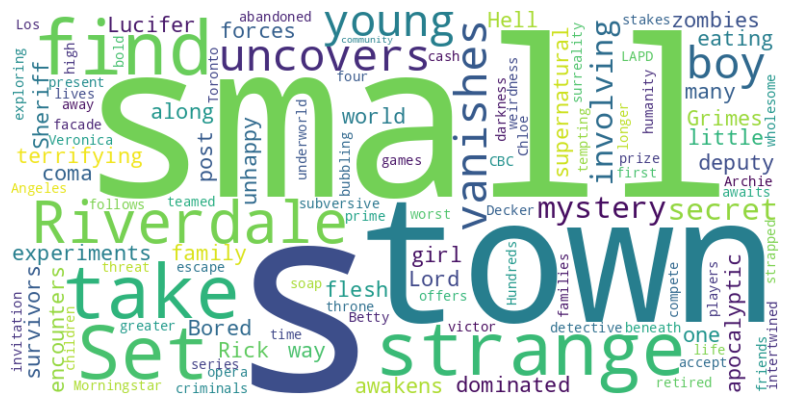

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to create a word cloud for the recommended TV shows
def create_wordcloud(recommendations):
    # Combine the overviews of recommended TV shows
    combined_overviews = ' '.join(df[df['name'].isin(recommendations)]['overview'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_overviews)

    # Plot the WordCloud image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Example: Create a word cloud for the recommendations
create_wordcloud(recommendations)


**Installing dash package**

In [ ]:
!pip install dash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 22.6 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

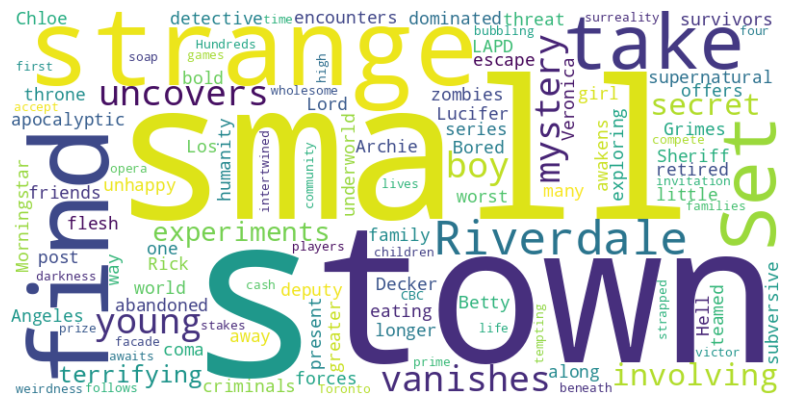

In [ ]:
import dash
from dash import dcc, html

# Sample recommendations data (replace this with your actual recommendations)
# recommendations = ['Show1', 'Show2', 'Show3', 'Show4', 'Show5']

# Create a Dash web application
app = dash.Dash(__name__)

# Define the layout of the web app
app.layout = html.Div([
    html.H1("TV Show Recommendations"),

    # Create a dynamic list of recommended shows
    html.H3("Recommended Shows:"),
    html.Ul(
        [html.Li(recommendation) for recommendation in recommendations]
    ),

    # You can include additional components or visualizations here based on your recommendations

])

# Run the web app
if __name__ == '__main__':
    app.run_server(debug=True)



from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to create a word cloud for the recommended TV shows
def create_wordcloud(recommendations):
    # Combine the overviews of recommended TV shows
    combined_overviews = ' '.join(df[df['name'].isin(recommendations)]['overview'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_overviews)

    # Plot the WordCloud image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Example: Create a word cloud for the recommendations
create_wordcloud(recommendations)


**Displaying the recommendaiton tv shows and number of seasons using bubble chart**

In [ ]:
import plotly.express as px

# Example: Get content-based recommendations for a user input
user_input = str(input("Enter a TV show title: ")) #'Breaking Bad'  # Replace with the user's input

recommendations = get_sophisticated_content_recommendations(user_input)
print("Sophisticated Content-Based Recommendations:")
print(recommendations)

import plotly.express as px

# Function to create a bubble chart for the recommendations
def create_bubble_chart(recommendations):
    # Filter the dataframe for recommended TV shows
    recommended_shows = df[df['name'].isin(recommendations)]

    # Create a bubble chart
    fig = px.scatter(recommended_shows, x='name', y='number_of_seasons',
                     size='number_of_episodes', color='genres',
                     hover_data=['languages'],
                     title='Recommended TV Shows (Bubble Chart)',
                     labels={'name': 'TV Show', 'number_of_seasons': 'Number of Seasons'},
                     size_max=50, height=500)

    # Show the chart
    fig.show()

# Example: Create a bubble chart for the recommendations
create_bubble_chart(recommendations)


Enter a TV show title: friends
Sophisticated Content-Based Recommendations:
['Colossal Machines', 'Tie The Not', 'The Keith And Paddy Picture Show', 'Colts: The Complete History', "Million Dollar Listing: Ryan's Renovation"]


**Getting the Recommendations using Bar Chart**

In [ ]:
import plotly.express as px

# Function to create a horizontal bar chart for the recommendations
def create_horizontal_bar_chart(recommendations, bar_color='blue'):
    # Filter the dataframe for recommended TV shows
    recommended_shows = df[df['name'].isin(recommendations)]

    # Creating a horizontal bar chart with custom color
    fig = px.bar(recommended_shows, x='name', y='number_of_seasons',
                 hover_data=['genres', 'languages'],
                 title='Recommended TV Shows',
                 labels={'name': 'TV Show', 'number_of_seasons': 'Number of Seasons'},
                 height=400,
                 color_discrete_sequence=[bar_color])

    # Showing the chart
    fig.show()

# Create a horizontal bar chart for the recommendations
create_horizontal_bar_chart(recommendations, bar_color='green')


**Getting the recommendations using Interactive HTML tag**

In [ ]:
from IPython.display import display, HTML
import ipywidgets as widgets

# Function to get sophisticated content-based recommendations (case-insensitive)
def get_sophisticated_content_recommendations(title):
    title_lower = title.lower()  # Convert user input to lowercase

    # Check if the entered title is in the dataset (case-insensitive)
    matching_titles = df['name'][df['name'].str.lower() == title_lower]

    if not matching_titles.empty:
        # Use the first matching title (in case of multiple matches)
        idx = df.index[df['name'].str.lower() == title_lower].tolist()
        if idx:
            idx = idx[0]
            sim_scores = list(enumerate(cosine_similarity_content[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

            # Check if there are enough recommendations
            if len(sim_scores) > 5:
                sim_scores = sim_scores[1:6]  # Get the top 5 similar shows (excluding itself)
                show_indices = [i[0] for i in sim_scores]
                return df['name'].iloc[show_indices].tolist()
            else:
                return "Error: Not enough recommendations available."
        else:
            return "Error: TV show index not found."
    else:
        return "TV show not found in the dataset. Please enter a different title."

# Function to display input box and recommendations
def get_user_input_and_display():
    # Create an input box for the user to enter the TV show title
    input_box = widgets.Text(placeholder="Enter a TV show title")
    display(input_box)

    # Create a button to trigger the recommendations display
    button = widgets.Button(description="Get Recommendations")
    display(button)

    # Function to handle button click and display recommendations
    def on_button_click(b):
        user_input = input_box.value
        recommendations = get_sophisticated_content_recommendations(user_input)

        # Display the recommendations
        display(HTML("<h3>Sophisticated Content-Based Recommendations:</h3>"))
        if isinstance(recommendations, list):
            for recommendation in recommendations:
                display(HTML(f"<li>{recommendation}</li>"))
        else:
            display(HTML(f"<p>{recommendations}</p>"))

    button.on_click(on_button_click)

# Call the function to get user input and display recommendations
get_user_input_and_display()


Text(value='', placeholder='Enter a TV show title')

Button(description='Get Recommendations', style=ButtonStyle())

**Getting the Recommendations with WordCloud**

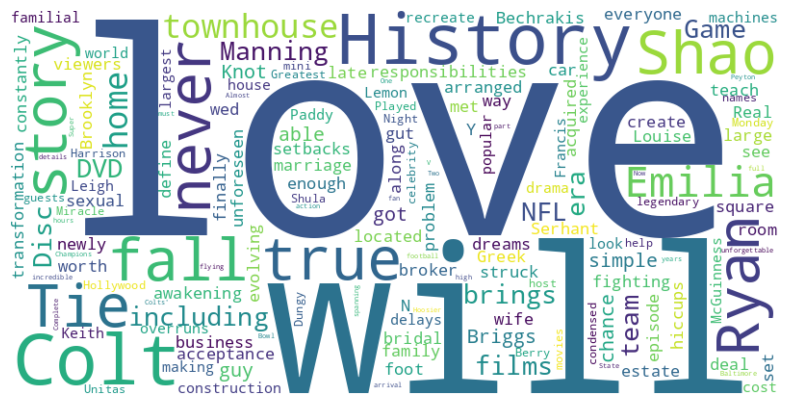

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to create a word cloud for the recommended TV shows
def create_wordcloud(recommendations):
    # Combine the overviews of recommended TV shows
    combined_overviews = ' '.join(df[df['name'].isin(recommendations)]['overview'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_overviews)

    # Plot the WordCloud image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Example: Create a word cloud for the recommendations
create_wordcloud(recommendations)
